##Download files

In [1]:
!git clone https://github.com/GlebBrykin/SANET.git

Cloning into 'SANET'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 139 (delta 21), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (139/139), 3.21 MiB | 2.99 MiB/s, done.
Resolving deltas: 100% (46/46), done.


In [2]:
%cd SANET
%pwd

/content/SANET


'/content/SANET'

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/ai_data_colab2/SANET.zip \
    -O SANET.zip

--2020-07-02 03:15:09--  https://storage.googleapis.com/ai_data_colab2/SANET.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104182767 (99M) [application/zip]
Saving to: ‘SANET.zip’

SANET.zip           100%[===================>]  99.36M   229MB/s    in 0.4s    

2020-07-02 03:15:10 (229 MB/s) - ‘SANET.zip’ saved [104182767/104182767]



In [4]:
import os
import zipfile
local_zip = 'SANET.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [5]:
!mv SANET/*.pth  .

##Execute style transfer

In [6]:
#arguments are not working!
#!python Eval.py --content 'input/chicago.jpg' --style 'style/udnie.jpg'

##Execute style transfer by code

In [7]:
import argparse
import os
import torch
import torch.nn as nn
from PIL import Image
from os.path import basename
from os.path import splitext
from torchvision import transforms
from torchvision.utils import save_image

def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std

def mean_variance_norm(feat):
    size = feat.size()
    mean, std = calc_mean_std(feat)
    normalized_feat = (feat - mean.expand(size)) / std.expand(size)
    return normalized_feat

decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)

class SANet(nn.Module):
    
    def __init__(self, in_planes):
        super(SANet, self).__init__()
        self.f = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.g = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.h = nn.Conv2d(in_planes, in_planes, (1, 1))
        self.sm = nn.Softmax(dim = -1)
        self.out_conv = nn.Conv2d(in_planes, in_planes, (1, 1))
        
    def forward(self, content, style):
        F = self.f(mean_variance_norm(content))
        G = self.g(mean_variance_norm(style))
        H = self.h(style)
        b, c, h, w = F.size()
        F = F.view(b, -1, w * h).permute(0, 2, 1)
        b, c, h, w = G.size()
        G = G.view(b, -1, w * h)
        S = torch.bmm(F, G)
        S = self.sm(S)
        b, c, h, w = H.size()
        H = H.view(b, -1, w * h)
        O = torch.bmm(H, S.permute(0, 2, 1))
        b, c, h, w = content.size()
        O = O.view(b, c, h, w)
        O = self.out_conv(O)
        O += content
        return O

class Transform(nn.Module):
    def __init__(self, in_planes):
        super(Transform, self).__init__()
        self.sanet4_1 = SANet(in_planes = in_planes)
        self.sanet5_1 = SANet(in_planes = in_planes)
        self.upsample5_1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.merge_conv_pad = nn.ReflectionPad2d((1, 1, 1, 1))
        self.merge_conv = nn.Conv2d(in_planes, in_planes, (3, 3))
    def forward(self, content4_1, style4_1, content5_1, style5_1):
        return self.merge_conv(self.merge_conv_pad(self.sanet4_1(content4_1, style4_1) + self.upsample5_1(self.sanet5_1(content5_1, style5_1))))

def test_transform():
    transform_list = []
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)
    return transform

### change the input and style images here

In [8]:
parser = argparse.ArgumentParser()

# Basic options
parser.add_argument('--content', type=str, default = 'input/chicago.jpg',   #'input/chicago.jpg'
                    help='File path to the content image')
parser.add_argument('--style', type=str, default = 'style/wave.jpg',     #'style/style11.jpg'
                    help='File path to the style image, or multiple style \
                    images separated by commas if you want to do style \
                    interpolation or spatial control')
parser.add_argument('--steps', type=str, default = 1)
parser.add_argument('--vgg', type=str, default = 'vgg_normalised.pth')
parser.add_argument('--decoder', type=str, default = 'decoder_iter_500000.pth')
parser.add_argument('--transform', type=str, default = 'transformer_iter_500000.pth')

# Additional options
parser.add_argument('--save_ext', default = '.jpg',
                    help='The extension name of the output image')
parser.add_argument('--output', type=str, default = 'output',
                    help='Directory to save the output image(s)')

# Advanced options

args = parser.parse_args('')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not os.path.exists(args.output):
    os.mkdir(args.output)

decoder = decoder
transform = Transform(in_planes = 512)
vgg = vgg

decoder.eval()
transform.eval()
vgg.eval()

decoder.load_state_dict(torch.load(args.decoder))
transform.load_state_dict(torch.load(args.transform))
vgg.load_state_dict(torch.load(args.vgg))

norm = nn.Sequential(*list(vgg.children())[:1])
enc_1 = nn.Sequential(*list(vgg.children())[:4])  # input -> relu1_1
enc_2 = nn.Sequential(*list(vgg.children())[4:11])  # relu1_1 -> relu2_1
enc_3 = nn.Sequential(*list(vgg.children())[11:18])  # relu2_1 -> relu3_1
enc_4 = nn.Sequential(*list(vgg.children())[18:31])  # relu3_1 -> relu4_1
enc_5 = nn.Sequential(*list(vgg.children())[31:44])  # relu4_1 -> relu5_1

norm.to(device)
enc_1.to(device)
enc_2.to(device)
enc_3.to(device)
enc_4.to(device)
enc_5.to(device)
transform.to(device)
decoder.to(device)

content_tf = test_transform()
style_tf = test_transform()

content = content_tf(Image.open(args.content))
style = style_tf(Image.open(args.style))

style = style.to(device).unsqueeze(0)
content = content.to(device).unsqueeze(0)

with torch.no_grad():

    for x in range(args.steps):

        print('iteration ' + str(x))
        
        Content4_1 = enc_4(enc_3(enc_2(enc_1(content))))
        Content5_1 = enc_5(Content4_1)
    
        Style4_1 = enc_4(enc_3(enc_2(enc_1(style))))
        Style5_1 = enc_5(Style4_1)
    
        content = decoder(transform(Content4_1, Style4_1, Content5_1, Style5_1))

        content.clamp(0, 255)

    content = content.cpu()
    
    output_name = '{:s}/{:s}_stylized_{:s}{:s}'.format(
                args.output, splitext(basename(args.content))[0],
                splitext(basename(args.style))[0], args.save_ext
            )
    save_image(content, output_name)

iteration 0


### show the result

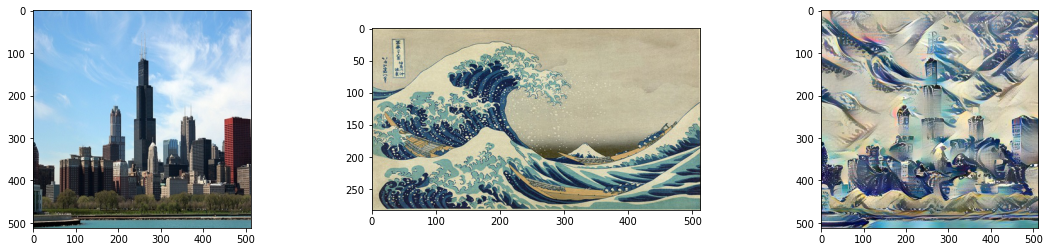

In [9]:
#show the images
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))

img = Image.open(args.content)
plt.subplot(1, 3, 1)
plt.imshow(img)

img = Image.open(args.style)
plt.subplot(1, 3, 2)
plt.imshow(img)

img = Image.open(output_name)
plt.subplot(1, 3, 3)
plt.imshow(img)

Reference: https://github.com/GlebBrykin/SANET